In [1]:
import sys
# Set the path to the repository here
sys.path.append("../")
import detr_tf
from detr_tf.inference import get_model_inference, numpy_bbox_to_image
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 1:
    print("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU


In [3]:
from detr_tf.training_config import TrainingConfig
from os.path import expanduser
import os

class CustomConfig(TrainingConfig):

    def __init__(self):
        super().__init__()        
        # Dataset info
        self.datadir = os.path.join("../data/WIDERface/")
        # The model is trained using fixed size images.
        # The following is the desired target image size, but it can be change based on your
        # dataset
        #self.image_size = (480, 720)
        self.image_size = 376, 672
        # Batch size
        self.batch_size = 1
        # Using the target batch size , the training loop will agregate the gradient on 38 steps
        # before to update the weights
        self.target_batch = 8

config = CustomConfig()

In [4]:
#For loading the WIDER FACE dataset


import tensorflow as tf
from random import shuffle
import pandas as pd
import imageio

from detr_tf.inference import numpy_bbox_to_image
from detr_tf import bbox
import numpy as np

from detr_tf.data import processing
from detr_tf.data.transformation import detr_transform

# Set the class name.
CLASS_NAMES = ["head"]
# Add the background class at the begining
CLASS_NAMES = ["background"] + CLASS_NAMES

def load_wider_data_from_index(index, class_names, filenames, train_val, anns, config, augmentation):
    # Open the image
    
    #image = imageio.imread(os.path.join(config.datadir, f"{train_val}", filenames[img_id]))
    image = imageio.imread(filenames[index])
    # Select all the annotatiom (bbox and class) on this image
    image_anns = anns[anns["filename"] == filenames[index]]    
    
    # Convert all string class to number (the target class)
    t_class = image_anns["class"].map(lambda x: class_names.index(x)).to_numpy()
    # Select the width&height of each image (should be the same since all the ann belongs to the same image)
    width = image_anns["width"].to_numpy()
    height = image_anns["height"].to_numpy()
    # Select the xmin, ymin, xmax and ymax of each bbox, Then, normalized the bbox to be between and 0 and 1
    # Finally, convert the bbox from xmin,ymin,xmax,ymax to x_center,y_center,width,height
    bbox_list = image_anns[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
    bbox_list = bbox_list / [width[0], height[0], width[0], height[0]] 
    t_bbox = bbox.xy_min_xy_max_to_xcycwh(bbox_list)
    
    # Transform and augment image with bbox and class if needed
    image, t_bbox, t_class = detr_transform(image, t_bbox, t_class, config, augmentation=augmentation)

    # Normalized image
    image = processing.normalized_images(image, config)
            
    return image.astype(np.float32), t_bbox.astype(np.float32), np.ndarray.astype(np.expand_dims(t_class, axis=-1), np.int64)

#np.expand_dims(t_class, axis=-1)

def load_wider(train_val,batch_size, config, augmentation=False):
    """ Load the hardhat dataset
    """
    anns = pd.read_csv(f'{train_val}.csv')
    print(anns)
    CLASS_NAMES = ["background"] + anns["class"].unique().tolist()
    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    shuffle(indexes)
    
    # Set the background class to 0
    unique_class = anns["class"].unique()
    unique_class.sort()
    config.background_class = 0
    class_names = ["background"] + unique_class.tolist()

    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    dataset = dataset.map(lambda idx: processing.numpy_fc(
        idx, load_wider_data_from_index, 
        class_names=class_names, filenames=filenames, train_val=train_val, anns=anns, config=config, augmentation=augmentation)
    ,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    

    # Filter labels to be sure to keep only sample with at least one bbox
    dataset = dataset.filter(lambda imgs, tbbox, tclass: tf.shape(tbbox)[0] > 0)
    # Pad bbox and labels
    dataset = dataset.map(processing.pad_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Batch images
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    return dataset, class_names

In [18]:
train = pd.read_csv('train.csv')
train

,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,../data/WIDERface/WIDER_train/images/0--Parade...,1024,1385,head,449,330,571,479
1,1,../data/WIDERface/WIDER_train/images/0--Parade...,1024,1432,head,361,98,624,437
2,2,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,78,221,85,229
3,3,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,78,238,92,255
4,4,../data/WIDERface/WIDER_train/images/0--Parade...,1024,768,head,113,212,124,227
...,...,...,...,...,...,...,...,...,...
101165,101165,../data/WIDERface/WIDER_train/images/9--Press_...,1024,683,head,462,140,726,502
101166,101166,../data/WIDERface/WIDER_train/images/9--Press_...,1024,1353,head,362,108,576,385
101167,101167,../data/WIDERface/WIDER_train/images/9--Press_...,1024,1536,head,495,222,660,444
101168,101168,../data/WIDERface/WIDER_train/images/9--Press_...,1024,705,head,244,46,754,660


In [6]:
from detr_tf.networks.detr import get_detr_model

#TransferLearning
detr = get_detr_model(config, include_top=False, nb_class=2, weights="detr")
#detr.load_weights("detr-learn-third10.ckpt")
detr.summary()

Load weights from weights/detr\detr.ckpt
(6, None, 100, 256)
Model: "detr_finetuning"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
detr (Model)                    (6, None, 100, 256)  41449152    input_2[0][0]                    
__________________________________________________________________________________________________
pos_layer (Sequential)          (6, None, 100, 4)    132612      detr[1][0]                       
__________________________________________________________________________________________________
cls_layer (Dense)               (6, None, 100, 2)    514         detr[1][0]                       
_______________________

In [ ]:
17363456+132612+514

In [7]:
detr.get_layer('detr').summary()

Model: "detr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
backbone (ResNet50Backbone)     (None, None, None, 2 23561152    input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp multiple             0           backbone[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Shape_1 (TensorFlow multiple             0           backbone[0][0]                   
_______________________________________________________________________________________________

In [8]:
# Train/finetune the transformers only
config.train_backbone = tf.Variable(False)
config.train_transformers = tf.Variable(True)
config.train_nlayers = tf.Variable(True)

config.nlayers_lr = tf.Variable(1e-3)

from detr_tf.optimizers import setup_optimizers
# Setup the optimziers and the trainable variables
optimzers = setup_optimizers(detr, config)

In [11]:
valid_iterator, valid_class_names = load_wider("val", config.batch_size, config, augmentation=False)

       Unnamed: 0                                           filename  width  \
0               0  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
1               1  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
2               2  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
3               3  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
4               4  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
...           ...                                                ...    ...   
25069       25069  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   
25070       25070  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   
25071       25071  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   
25072       25072  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   
25073       25073  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   

       height class  xmin  ymin  xmax  ymax  
0    

## Transfer learning

In [ ]:
from detr_tf import training

for epoch in range(1,100):
    
    training.eval(detr, valid_iterator, config, valid_class_names, evaluation_step=200)
    training.fit(detr, train_iterator, optimzers, config, epoch_nb=epoch, class_names=class_names)
    #Save the model
    detr.save_weights("detr-model-wider.ckpt")

In [14]:
detr.load_weights("detr-model-wider.ckpt")

## Testing

In [7]:
#detr.load_weights("detr-learn-third10.ckpt")
detr.load_weights("detr-transfolearn-third.ckpt")

In [8]:
from detr_tf.data import load_wider_test

test_iterator, class_names = load_wider_test(config.batch_size, config, augmentation=False,exclude=[])

                                               filename  width  height class  \
0     ../data/WIDERface/WIDER_test/images/0--Parade/...   1024     653  head   
1     ../data/WIDERface/WIDER_test/images/0--Parade/...   1024     684  head   
2     ../data/WIDERface/WIDER_test/images/0--Parade/...   1024     751  head   
3     ../data/WIDERface/WIDER_test/images/0--Parade/...   1024     578  head   
4     ../data/WIDERface/WIDER_test/images/0--Parade/...   1024     681  head   
...                                                 ...    ...     ...   ...   
5362  ../data/WIDERface/WIDER_test/images/21--Festiv...   1024    1366  head   
5363  ../data/WIDERface/WIDER_test/images/21--Festiv...   1024     683  head   
5364  ../data/WIDERface/WIDER_test/images/21--Festiv...   1024    1289  head   
5365  ../data/WIDERface/WIDER_test/images/21--Festiv...   1024     683  head   
5366  ../data/WIDERface/WIDER_test/images/21--Festiv...   1024     682  head   

        x    y  w  h  
0     0.0  0.0  

In [15]:
%load_ext autoreload
%autoreload 2

import importlib
importlib.reload(detr_tf.inference)
from detr_tf.inference import get_model_inference, numpy_bbox_to_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Done predictions with time 3.925 s
(376, 672, 3) (1, 4)
(1,)


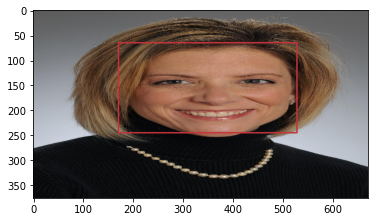

Done predictions with time 0.459 s
(376, 672, 3) (1, 4)
(1,)


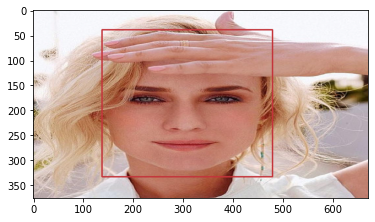

Done predictions with time 0.491 s
(376, 672, 3) (2, 4)
(2,)


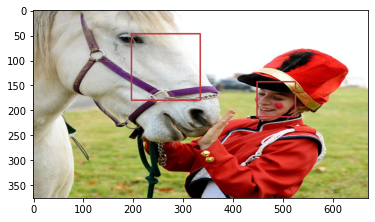

Done predictions with time 0.479 s
(376, 672, 3) (1, 4)
(1,)


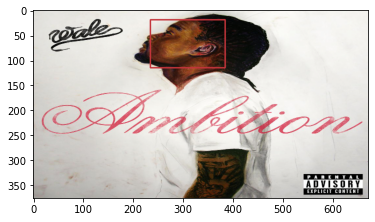

Done predictions with time 0.477 s
(376, 672, 3) (0, 4)
(0,)


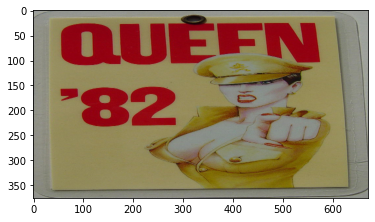

Done predictions with time 0.468 s
(376, 672, 3) (21, 4)
(21,)


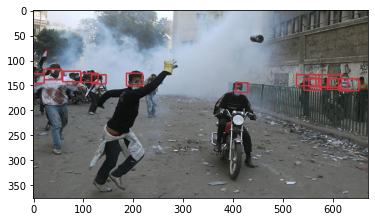

Done predictions with time 0.490 s
(376, 672, 3) (1, 4)
(1,)


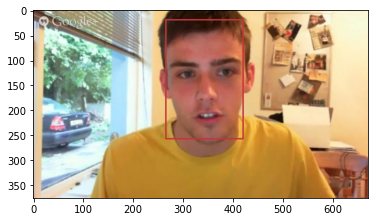

Done predictions with time 0.476 s
(376, 672, 3) (28, 4)
(28,)


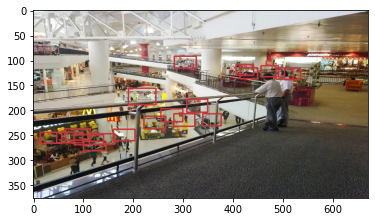

Done predictions with time 0.466 s
(376, 672, 3) (6, 4)
(6,)


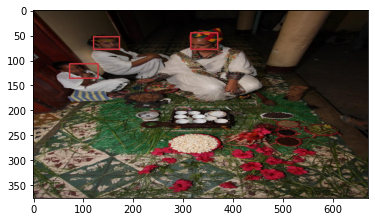

Done predictions with time 0.488 s
(376, 672, 3) (8, 4)
(8,)


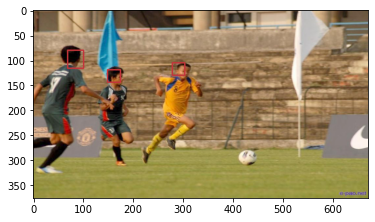

Done predictions with time 0.484 s
(376, 672, 3) (20, 4)
(20,)


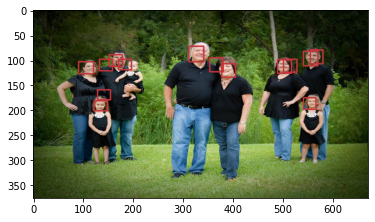

Done predictions with time 0.479 s
(376, 672, 3) (62, 4)
(62,)


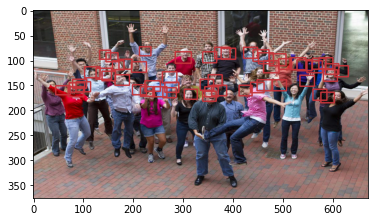

Done predictions with time 0.465 s
(376, 672, 3) (5, 4)
(5,)


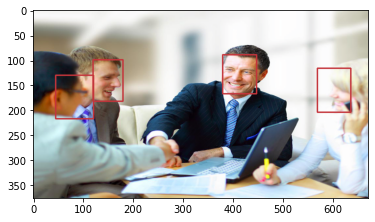

Done predictions with time 0.446 s
(376, 672, 3) (5, 4)
(5,)


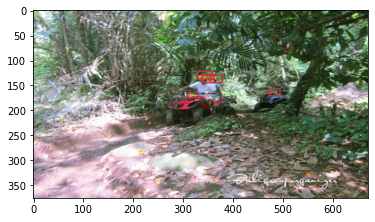

Done predictions with time 0.467 s
(376, 672, 3) (38, 4)
(38,)


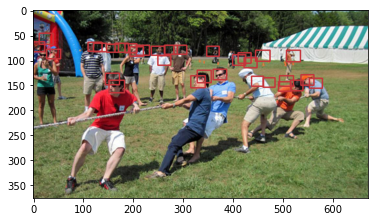

Done predictions with time 0.459 s
(376, 672, 3) (81, 4)
(81,)


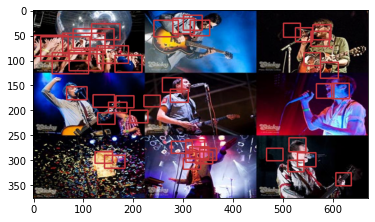

Done predictions with time 0.475 s
(376, 672, 3) (20, 4)
(20,)


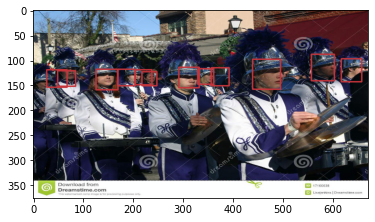

Done predictions with time 0.458 s
(376, 672, 3) (6, 4)
(6,)


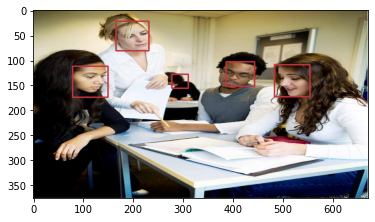

Done predictions with time 0.466 s
(376, 672, 3) (100, 4)
(100,)


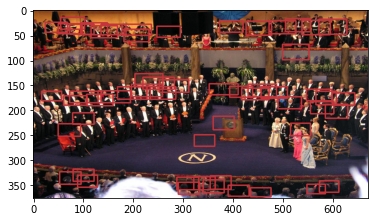

Done predictions with time 0.476 s
(376, 672, 3) (6, 4)
(6,)


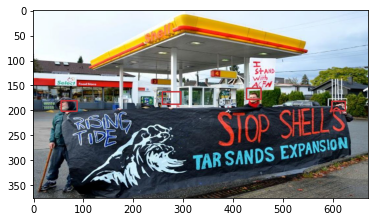

Done predictions with time 0.457 s
(376, 672, 3) (100, 4)
(100,)


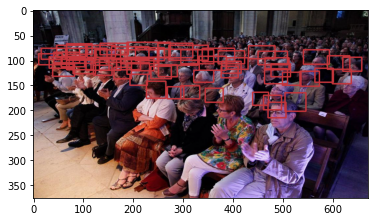

In [17]:
i=0

for valid_images, target_bbox, target_class in test_iterator:
    
    start = time.time()
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")
    print("Done predictions with time %.3f s"%(time.time()-start))
    #print(predicted_scores)
    
    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=class_names, 
        config=config
    )
    plt.imshow(result)
    #plt.savefig("pic%i.jpg"%i)
    plt.show()
    i+=1
    if i>20:
        break

In [50]:
def nms(boxes, scores, overlap=0.5, top_k=200):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    scores = np.array(scores)
    scores = torch.tensor(scores)
    #boxes = boxes.numpy()
    boxes = torch.tensor(boxes)
    print(scores.shape)
    keep = scores.new(scores.size(0)).zero_().long()
    #keep = tf.fill(scores.shape, 0.0)
    #keep = tf.fill(tf.shape(Y), 0.0)
    #print(tf.size(boxes).numpy())
    #if tf.size(boxes).numpy() == 0:
    if boxes.numel() ==0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    #area = (x2-x1)*(y2-y1)
    v, idx = scores.sort(0)  # sort in ascending order
    #idx = np.argsort(scores)
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w * h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter / union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep.numpy(), count

In [51]:
nms(boxes, predicted_scores)

torch.Size([1])


(array([0], dtype=int64), 1)